In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from tqdm import tqdm


In [2]:
# Helper functions

def p(vector : np.ndarray) -> np.ndarray:
    
    denominator = 1 + np.exp(-2*np.asarray(vector))
    
    return 1/denominator
    

def DKL(dist: np.ndarray) -> float:
    pd = np.asarray([1/4, 1/4, 1/4, 1/4, 0, 0, 0, 0])
    
    dkl = 0
    for i in range(4):
        if pd[i] > 0 and dist[i] > 0:
            dkl += pd[i] * np.log(pd[i]/dist[i])
        
        elif pd[i] == 0 and dist[i] > 0:
            dkl += 0
        
        else:
            dkl += np.infty
            
            
    return dkl


def DKLT(m: int) -> float:
    if m < 2**(2) - 1:
        dklt = np.log2(3 - np.floor(np.log2(m+1)) -(m+1)/(2**np.floor(np.log2(m+1))))
    else:
        dklt = 0
    
    return dklt
    

In [3]:
class RBM:
    
    
    def __init__(self, M, k):
        self.M = M
        self.k = k
        self.v = np.zeros((3,))
        self.h = np.zeros((M,))
        self.w = np.random.normal(0,1/3,(M,3))
        self.tv = np.zeros((3,))
        self.th = np.zeros((M,))
        self.eta = 0.0025
        
        
    def train(self, train_patterns):
#         print(train_patterns)
        for _ in tqdm(range(500)): # 100 realisations
            # sample 20 different patterns
            dw = np.zeros(shape=self.w.shape)
            dth = np.zeros((self.M,))
            dtv = np.zeros((3,))
            
            for __ in range(64):
                idx = np.random.choice(len(train_patterns))
                # print(idx)
                mu = np.asarray(train_patterns[idx].copy())
#                 print(mu)
                self.v[:] = mu[:]
                v0 = np.asarray(mu)
                bh0 = self.w @ v0 - self.th
                
                probs = p(bh0)
                r = np.random.rand(self.M)
                self.h[:] = -1
                self.h[r < probs] = 1
                
                for t in range(self.k):
                    bv = np.dot(self.h,self.w) - self.tv
                    probs = p(bv)
                    r = np.random.rand(3)
                    self.v[:] = -1
                    self.v[r < probs] = 1
                    
                    bh = self.w @ self.v - self.th
                    probs = p(bh)
                    r = np.random.rand()
                    self.h[:] = -1
                    self.h[r < probs] = 1
                
                
                dw += self.eta   * (np.outer(np.tanh(bh0), v0) - np.outer(np.tanh(bh), self.v))
                dtv += -self.eta * (v0 - self.v)
                dth += -self.eta * (np.tanh(bh0) - np.tanh(bh))
            
            self.w += dw
            self.tv += dtv
            self.th += dth
            
            
    def compute_distribution(self, patterns):
        
        #feed 4000 patterns
        dist = np.zeros((len(patterns),))
        
        for _ in tqdm(range(2000)):
            idx = np.random.choice(len(patterns))
            mu = patterns[idx].copy()
            self.v = np.asarray(mu)
            # print(self.v)
            bh = self.w @ self.v - self.th
            probs = p(bh)
            r = np.random.rand(self.M)
            
            self.h[:] = -1
            self.h[r < probs] = 1
            
            for tt in range(1000):
                bv = np.dot(self.h,self.w) - self.tv
                probs = p(bv)
                r = np.random.rand(3)
                self.v[:] = -1
                self.v[r < probs] = 1

                bh = self.w @ self.v - self.th
                probs = p(bh)
                r = np.random.rand(self.M)
                self.h[:] = -1
                self.h[r < probs] = 1
        
            
                # find what pattern we our visible neurons correspond to
                # print(self.v)
                for i, pattern in enumerate(patterns):

                    if np.array_equal(pattern, self.v):
                        dist[i] += 1
                        #print(pattern)
        # print(patterns)
        return dist/np.sum(dist)
    
    

In [4]:
patterns = [[-1,-1,-1], [1,-1,1], [-1,1,1], [1,1,-1],
            [1,1,1], [-1,1,-1], [1,-1,-1], [-1,-1,1]]

M_vec = [1]
DKLs = []
for M in M_vec:

    rbm = RBM(M, 600)
    rbm.train([[-1,-1,-1], [1,-1,1], [-1,1,1], [1,1,-1]])
    print(f'M = {M : <2} trained')
    dist = rbm.compute_distribution(patterns)
    print(f'M = {M : <2} distribution found')
    print(dist)
    DKLs.append(DKL(dist))
    print(f'M = {M : <2} DKL = {DKL(dist)}')
print(DKLs)
print(rbm.w)
print(rbm.tv)
print(rbm.th)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [11:29<00:00,  1.38s/it]


M = 1  trained


  8%|██████▎                                                                        | 159/2000 [00:17<03:19,  9.25it/s]


KeyboardInterrupt: 

In [5]:
print(rbm.w)
print(rbm.tv)
print(rbm.th)

[[-0.90148599 -0.89125018 -0.88498426]]
[0.595 0.665 0.64 ]
[1.90180645]


In [35]:
rbm = RBM(4, 600)
rbm.train([[-1,-1,-1], [1,-1,1], [-1,1,1], [1,1,-1]])
dist = rbm.compute_distribution(patterns)
print(DKL(dist))

# 1 : 0.6084250750269431
# 2 : 0.3922060686634546
# 4 : 0.09855227243568195
# 8 : 0.02495332853808071


0.5846188316518818


In [10]:
dkls =  [0.6084250750269431,
        0.3922060686634546,
        0.09855227243568195,
        0.02495332853808071]

In [46]:
import pickle as pkl
values = [rbm.eta, rbm.w, rbm.th, rbm.tv, rbm.k, DKLs]
# with open('values_M8.pkl', 'wb') as f:
#     pkl.dump(values, f)

In [14]:
DKLTs = []
for m in M_vec:
    DKLTs.append(DKLT(m))
print(DKLTs)
print(DKLT(2))

[0.0, -1.0, 0, 0]
-1.0


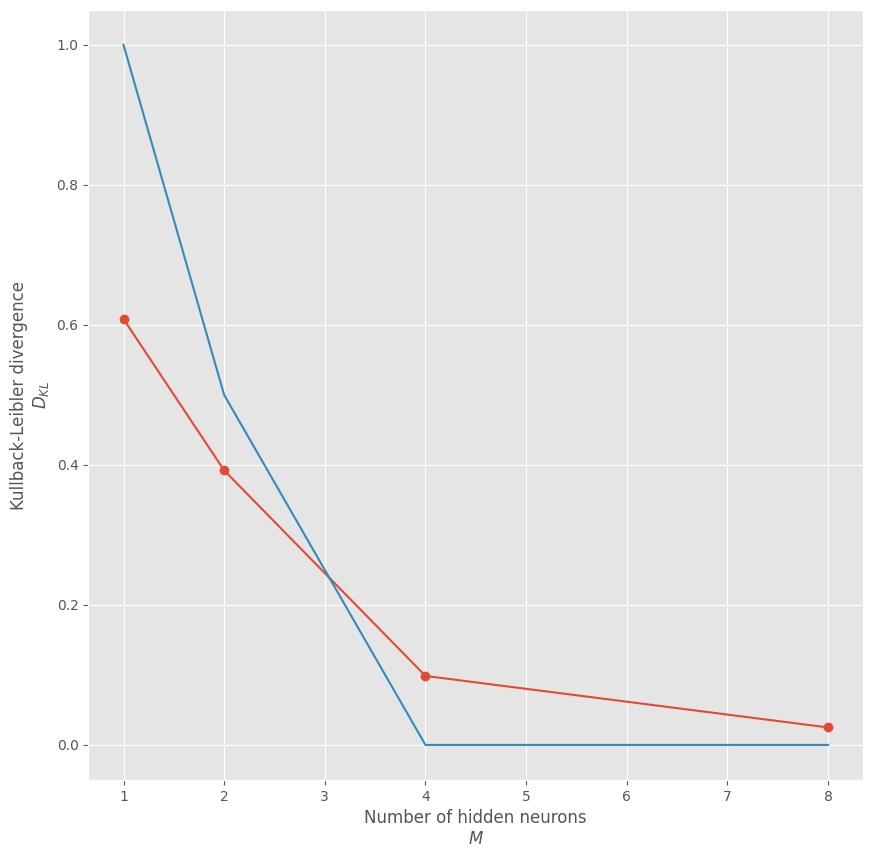

In [12]:
f = plt.figure(figsize=(10,10))
plt.plot(M_vec, dkls, marker='o')
plt.plot(M_vec, DKLTs)
plt.xlabel('Number of hidden neurons\n$M$')
plt.ylabel('Kullback-Leibler divergence\n$D_{KL}$')
#[3.6586504966153273, 0.993283968604459, 0.04249513728802652, 0.002175759132900648]
plt.savefig('DKL_M.png')
plt.show()
